# Prompt Chaining con LangGraph

## Definición (nivel MIT/Stanford, aplicada)
Prompt Chaining separa un problema en pasos secuenciales con estado explícito. Cada nodo produce una pieza verificable y el siguiente nodo opera sobre evidencia, no sobre intuición.

## Cuándo usarla
Usa esta arquitectura cuando necesitas control y trazabilidad en tareas multi-paso: análisis -> draft -> mejora -> salida final.

## Cuándo NO usarla
No la uses si una sola llamada produce calidad estable; pagarías latencia sin beneficio real.

## Diagrama Conceptual

```mermaid
graph TD
A[Contexto] --> B[Analizar]
B --> C[Draft]
C --> D{Gate}
D -->|pass| E[Final]
D -->|fail| F[Refinar]
F --> E
```

In [1]:
# Setup de clase
from __future__ import annotations

import importlib.util
import inspect
import json
import sys
from pathlib import Path
from IPython.display import Image, Markdown, display


def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists():
            return p
    raise RuntimeError("No se encontro raiz del repo")


def load_module(path: Path, module_name: str):
    spec = importlib.util.spec_from_file_location(module_name, path)
    module = importlib.util.module_from_spec(spec)
    if spec is None or spec.loader is None:
        raise RuntimeError(f"No se pudo cargar modulo: {path}")
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

ROOT = find_repo_root(Path.cwd())
print(f"Repo root: {ROOT}")

Repo root: /Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry


In [2]:
script_path = ROOT / '04_langchain_langgraph/01_prompt_chaining/Notebooks/01_prompt_chaining_langgraph.py'
module = load_module(script_path, 'nb_prompt_chain')
run_fn = module.run_prompt_chaining
print('Script:', script_path)
print('Función:', run_fn.__name__)

Script: /Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/04_langchain_langgraph/01_prompt_chaining/Notebooks/01_prompt_chaining_langgraph.py
Función: run_prompt_chaining


## Código de la arquitectura (visible en notebook)

In [3]:
print(inspect.getsource(run_fn)[:5000])

def run_prompt_chaining(profile: dict | None = None, verbose: bool = True) -> dict:
    root = find_repo_root(Path.cwd())
    load_dotenv(root / ".env")
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        raise RuntimeError("OPENAI_API_KEY no esta definida en .env")

    model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
    llm = ChatOpenAI(model=model, temperature=0.5, api_key=api_key)

    build_context_packet = load_context_builder(root)
    if profile is None:
        profile = {
            "tipo_persona": "productora musical de jazz contemporaneo",
            "gustos": ["vinilos de Coltrane", "cocina japonesa izakaya", "fotografia analogica"],
            "estilo": "creativa, espontanea, valora referencias culturales",
            "contexto": "conversacion retomada tras 3 dias",
        }
    context_packet = build_context_packet(profile=profile, architecture="prompt_chaining")

    def analyze_signals(state: ChainState) -> dict:
        prompt = ChatPromptTempl

## Ejemplo 1: caso base del curso

In [4]:
result_1 = run_fn(verbose=False)
print('Modelo:', result_1['__model'])
print('Context hash:', result_1['__context_hash'])

Modelo: gpt-4o-mini
Context hash: e50a331051a8


In [5]:
print('Salida final ejemplo 1:')
print(json.dumps(result_1['final'], ensure_ascii=False, indent=2))

Salida final ejemplo 1:
{
  "opener": "¡Hola! Espero que estos días hayan sido inspiradores para ti. Me quedé pensando en nuestra última charla sobre vinilos de Coltrane y cómo su música puede ser tan evocadora. ¿Has tenido la oportunidad de escuchar algo nuevo últimamente?",
  "follow_up": "Además, me encantaría saber si has probado alguna nueva receta de cocina japonesa izakaya. Siempre es un placer intercambiar ideas sobre platos y sabores que nos inspiran. ¿Qué te parece?",
  "why_it_works": [
    "El saludo inicial establece un tono amigable y positivo, mostrando interés genuino por el bienestar del otro.",
    "Referirse a la conversación anterior sobre Coltrane crea una conexión emocional y refuerza el interés compartido en la música.",
    "Preguntar sobre novedades en su escucha musical invita a la persona a compartir sus experiencias recientes, fomentando un diálogo más profundo.",
    "Incluir la cocina japonesa izakaya no solo respeta sus gustos, sino que también abre la pu

## Grafo real LangGraph (comportamiento)

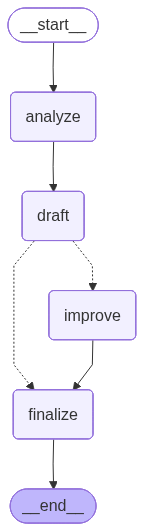

In [6]:
agent = result_1['__agent']
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as exc:
    print('No se pudo renderizar PNG en este entorno:', exc)
    display(Markdown('```mermaid\n' + result_1['__graph_mermaid'] + '\n```'))

## Ejemplo 2: asistente latino experto en enamorar (coqueteo creativo y respetuoso)

In [7]:
profile_coqueteo = {
  "tipo_persona": "asistente latino experto en enamorar con elegancia",
  "gustos": [
    "salsa romantica",
    "cafes bohemios",
    "poesia urbana",
    "paseos nocturnos"
  ],
  "estilo": "carismatico, coqueto, respetuoso, humor picante sutil",
  "contexto": "quiere iniciar una conversacion de coqueteo sin caer en frases prefabricadas"
}
result_2 = run_fn(profile=profile_coqueteo, verbose=False)
print('Context hash coqueteo:', result_2['__context_hash'])

Context hash coqueteo: 762195631e91


In [8]:
print('Salida final ejemplo coqueteo:')
print(json.dumps(result_2['final'], ensure_ascii=False, indent=2))

Salida final ejemplo coqueteo:
{
  "opener": "Hola, me encanta cómo la salsa romántica puede transformar un momento cualquiera en algo especial. ¿Tienes alguna canción favorita que te haga soñar?",
  "follow_up": "Además, me encantaría saber si disfrutas de esos paseos nocturnos por la ciudad, donde las luces y las sombras cuentan historias. ¿Tienes un lugar favorito para perderte un rato?",
  "why_it_works": [
    "Utiliza intereses compartidos como la salsa romántica y los paseos nocturnos para establecer una conexión.",
    "Invita a la otra persona a compartir sus gustos, lo que fomenta una conversación más profunda y personal.",
    "El tono es carismático y coqueto, sin ser explícito ni manipulador, manteniendo el respeto y la elegancia."
  ]
}


## Errores típicos en producción
- Elegir esta arquitectura por moda y no por necesidad.
- No definir métricas de calidad/costo/latencia antes de escalar.
- No versionar contexto ni criterios de evaluación.
- Falta de observabilidad para diagnosticar degradaciones.

## Lectura crítica del resultado
- Evalúa si el flujo realmente mejoró calidad o solo añadió complejidad.
- Compara latencia/costo vs beneficio de control arquitectónico.
- Decide si esta arquitectura es mínima suficiente para tu caso real.